Maximum accuracy on test data:  0.9


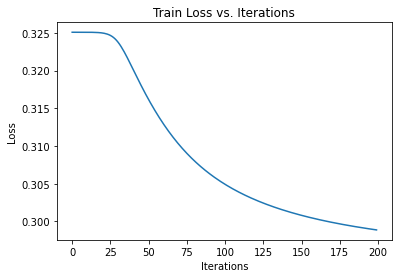

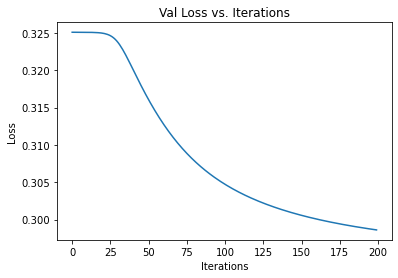

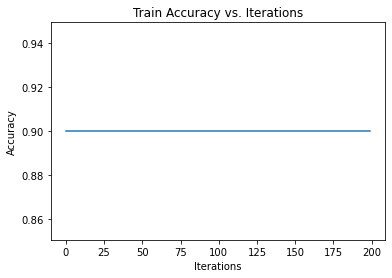

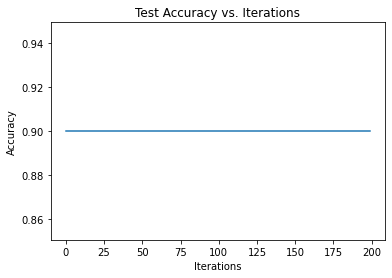

Maximum accuracy on test data:  0.9


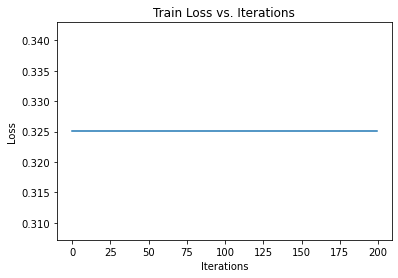

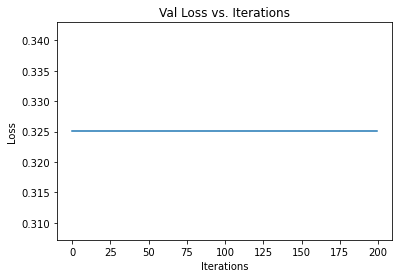

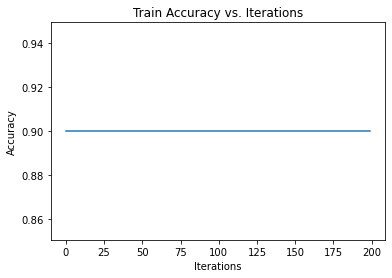

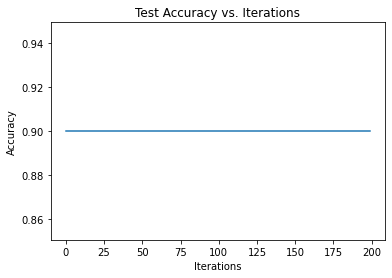

Maximum accuracy on test data:  0.87019


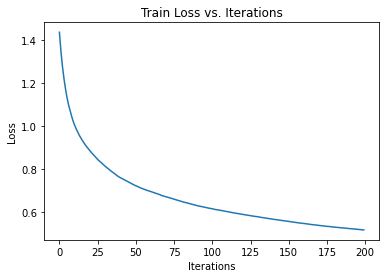

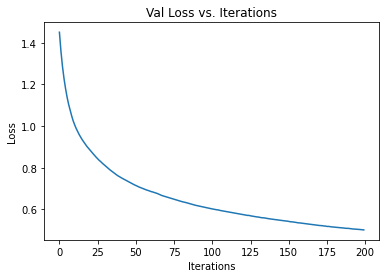

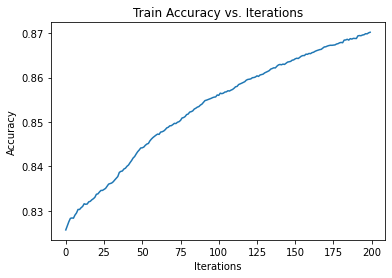

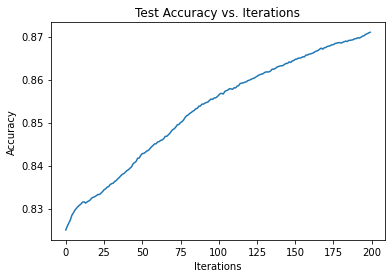

C:\Users\HP\AppData\Local\Temp\ipykernel_6232\1881409863.py:64: RuntimeWarning: invalid value encountered in true_divide
  return e_x / e_x.sum(axis=1, keepdims=True)


Maximum accuracy on test data:  0.9


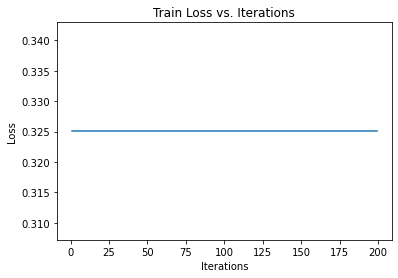

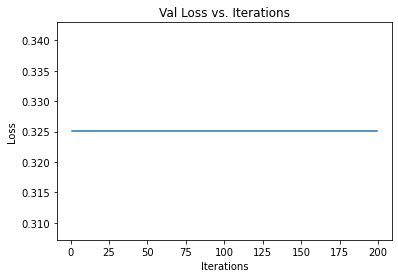

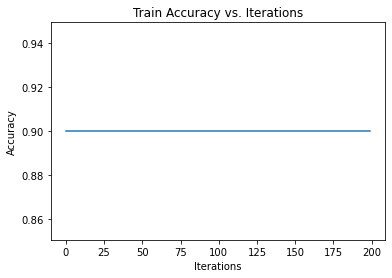

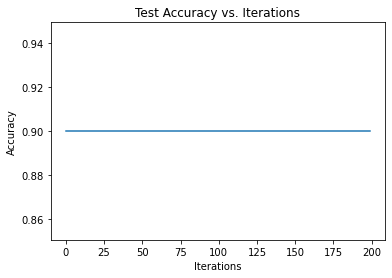

In [33]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd

#############################  Load Dataset and split into train, test, validation   ####################################

train_data = pd.read_csv('C:/Users/HP/Desktop/fashion-mnist_train.csv')
test_data = pd.read_csv("C:/Users/HP/Desktop/fashion-mnist_test.csv")

# Split data into features and labels
X_train = train_data.drop("label", axis=1).values

X_test= test_data.drop("label", axis=1).values
y_train = train_data["label"].values
y_test = test_data["label"].values

# Perform one-hot encoding of labels
one_hot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = one_hot_encoder.transform(y_test.reshape(-1, 1))

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, num_classes, init_type='zeros'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_classes = num_classes
        self.init_type = init_type
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.m = X_train.shape[1]
        self.y_test = y_test
        self.num_classes = num_classes
        self.y_train_onehot = np.eye(num_classes)[y_train.reshape(-1)]
        self.initialize_weights()

    def sigmoid(self, z):
        z = np.clip(z, -700, 700) # prevent overflow
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0) * 1.0

    def softmax(self, x):
        x = np.array(x)
        x = np.where(np.isnan(x), -sys.float_info.max, x)
        x = np.where(np.isinf(x), sys.float_info.max, x)
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=1, keepdims=True)
    
    def initialize_weights(self): #for zero initialization
        W1 = np.zeros((self.input_size, self.hidden_size))
        b1 = np.zeros((1, self.hidden_size))
        W2 = np.zeros((self.hidden_size, self.output_size))
        b2 = np.zeros((1, self.output_size))
        return W1, b1, W2, b2
    
    def initialize_weights1(self): #for normal initialization
        W1 = np.random.normal(size=(self.input_size, self.hidden_size))
        b1 = np.random.normal(size=(1, self.hidden_size))
        W2 = np.random.normal(size=(self.hidden_size, self.output_size))
        b2 = np.random.normal(size=(1, self.output_size))
        return W1, b1, W2, b2
    
################################################# Sigmoid  + Zeros #######################################################
    def train1(self, X_train, y_train_onehot, X_test, y_test_onehot,X_val, y_val_onehot, learning_rate=0.01, num_iterations=200):
        W1, b1, W2, b2 = self.initialize_weights()
        m = X_train.shape[0]
        
        loss_history = []
        loss_history1 = []
        accuracy_history = []
        acc_train = []
        acc_val = []

        for i in range(num_iterations):
            # Forward pass
            z1 = np.dot(X_train, W1) + b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)

            # Calculate loss
            eps = 1e-10 # small constant to prevent division by zero
            loss = -np.mean(y_train_onehot * np.log(a2 + eps) + (1 - y_train_onehot) * np.log(1 - a2 + eps))
            loss_history.append(loss)
            
            # Backward pass
            dz2 = a2 - y_train_onehot
            da1 = np.dot(dz2, W2.T) * self.sigmoid_derivative(a1)
            dW2 = np.dot(a1.T, dz2) / m
            db2 = np.sum(dz2, axis=0, keepdims=True) / m
            dW1 = np.dot(X_train.T, da1) / m
            db1 = np.sum(da1, axis=0, keepdims=True) / m
            
            z1 = np.dot(X_val, W1) + b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)

            # Calculate loss
            eps = 1e-10 # small constant to prevent division by zero
            loss = -np.mean(y_val_onehot * np.log(a2 + eps) + (1 - y_val_onehot) * np.log(1 - a2 + eps))
            loss_history1.append(loss)

            # Backward pass
            dz2 = a2 - y_val_onehot
            da1 = np.dot(dz2, W2.T) * self.sigmoid_derivative(a1)
            dW2 = np.dot(a1.T, dz2) / m
            db2 = np.sum(dz2, axis=0, keepdims=True) / m
            dW1 = np.dot(X_val.T, da1) / m
            db1 = np.sum(da1, axis=0, keepdims=True) / m

            # Update weights and biases
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2

            # Predict on test data
            z1 = np.dot(X_test, W1) + b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)

            # Calculate accuracy on test data
            predictions = np.round(a2)
            accuracy = np.mean(np.equal(predictions, y_test_onehot).astype(int))    
            accuracy_history.append(accuracy)
            
            # Calculate accuracy on train data
            z1 = np.dot(X_train, W1) + b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)
            
            predictions1 = np.round(a2)
            accuracy = np.mean(np.equal(predictions1, y_train_onehot).astype(int))    
            acc_train.append(accuracy)

            
            # Calculate accuracy on train data
            z1 = np.dot(X_val, W1) + b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)
            
            predictions1 = np.round(a2)
            accuracy = np.mean(np.equal(predictions1, y_val_onehot).astype(int))    
            acc_val.append(accuracy)
            
        print("Maximum accuracy on test data: ", max(accuracy_history))

        
        # Plot the accuracy curve
        plt.plot(loss_history)
        plt.title("Train Loss vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
        
        # Plot the accuracy curve
        plt.plot(loss_history1)
        plt.title("Val Loss vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
        
        
        # Plot the loss curve
        plt.plot(accuracy_history)
        plt.title("Train Accuracy vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.show()

        plt.plot(acc_val)
        plt.title("Test Accuracy vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.show()
        
################################################# Relu  + Zeros #######################################################        
    def train2(self, X_train, y_train_onehot, X_test, y_test_onehot,X_val, y_val_onehot, learning_rate=0.01, num_iterations=200):
        W1, b1, W2, b2 = self.initialize_weights()
        m = X_train.shape[0]
        
        loss_history = []
        loss_history1 = []
        accuracy_history = []
        acc_train = []
        acc_val = []

        for i in range(num_iterations):
            # Forward pass
            z1 = np.dot(X_train, W1) + b1
            a1 = self.relu(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)

            # Calculate loss
            eps = 1e-10 # small constant to prevent division by zero
            loss = -np.mean(y_train_onehot * np.log(a2 + eps) + (1 - y_train_onehot) * np.log(1 - a2 + eps))
            loss_history.append(loss)
            
            # Backward pass
            dz2 = a2 - y_train_onehot
            da1 = np.dot(dz2, W2.T) * self.relu_derivative(a1)
            dW2 = np.dot(a1.T, dz2) / m
            db2 = np.sum(dz2, axis=0, keepdims=True) / m
            dW1 = np.dot(X_train.T, da1) / m
            db1 = np.sum(da1, axis=0, keepdims=True) / m
            
            z1 = np.dot(X_val, W1) + b1
            a1 = self.relu(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)

            # Calculate loss
            eps = 1e-10 # small constant to prevent division by zero
            loss = -np.mean(y_val_onehot * np.log(a2 + eps) + (1 - y_val_onehot) * np.log(1 - a2 + eps))
            loss_history1.append(loss)

            # Backward pass
            dz2 = a2 - y_val_onehot
            da1 = np.dot(dz2, W2.T) * self.relu_derivative(a1)
            dW2 = np.dot(a1.T, dz2) / m
            db2 = np.sum(dz2, axis=0, keepdims=True) / m
            dW1 = np.dot(X_val.T, da1) / m
            db1 = np.sum(da1, axis=0, keepdims=True) / m

            # Update weights and biases
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2

            # Predict on test data
            z1 = np.dot(X_test, W1) + b1
            a1 = self.relu(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)

            # Calculate accuracy on test data
            predictions = np.round(a2)
            accuracy = np.mean(np.equal(predictions, y_test_onehot).astype(int))    
            accuracy_history.append(accuracy)
            
            # Calculate accuracy on train data
            z1 = np.dot(X_train, W1) + b1
            a1 = self.relu(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)
            
            predictions1 = np.round(a2)
            accuracy = np.mean(np.equal(predictions1, y_train_onehot).astype(int))    
            acc_train.append(accuracy)

            
            # Calculate accuracy on train data
            z1 = np.dot(X_val, W1) + b1
            a1 = self.relu(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)
            
            predictions1 = np.round(a2)
            accuracy = np.mean(np.equal(predictions1, y_val_onehot).astype(int))    
            acc_val.append(accuracy)
            
        print("Maximum accuracy on test data: ", max(accuracy_history))

        
        # Plot the accuracy curve
        plt.plot(loss_history)
        plt.title("Train Loss vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
        
        # Plot the accuracy curve
        plt.plot(loss_history1)
        plt.title("Val Loss vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
        
        
        # Plot the loss curve
        plt.plot(accuracy_history)
        plt.title("Train Accuracy vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.show()

        plt.plot(acc_val)
        plt.title("Test Accuracy vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.show()
        
################################################# Sigmoid  + Normal #######################################################
    def train3(self, X_train, y_train_onehot, X_test, y_test_onehot,X_val, y_val_onehot, learning_rate=0.1, num_iterations=200):
        W1, b1, W2, b2 = self.initialize_weights1()
        m = X_train.shape[0]
        
        loss_history = []
        loss_history1 = []
        accuracy_history = []
        acc_train = []
        acc_val = []

        for i in range(num_iterations):
            # Forward pass
            z1 = np.dot(X_train, W1) + b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)

            # Calculate loss
            eps = 1e-10 # small constant to prevent division by zero
            loss = -np.mean(y_train_onehot * np.log(a2 + eps) + (1 - y_train_onehot) * np.log(1 - a2 + eps))
            loss_history.append(loss)
            
            # Backward pass
            dz2 = a2 - y_train_onehot
            da1 = np.dot(dz2, W2.T) * self.sigmoid_derivative(a1)
            dW2 = np.dot(a1.T, dz2) / m
            db2 = np.sum(dz2, axis=0, keepdims=True) / m
            dW1 = np.dot(X_train.T, da1) / m
            db1 = np.sum(da1, axis=0, keepdims=True) / m
            
            z1 = np.dot(X_val, W1) + b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)

            # Calculate loss
            eps = 1e-10 # small constant to prevent division by zero
            loss = -np.mean(y_val_onehot * np.log(a2 + eps) + (1 - y_val_onehot) * np.log(1 - a2 + eps))
            loss_history1.append(loss)

            # Backward pass
            dz2 = a2 - y_val_onehot
            da1 = np.dot(dz2, W2.T) * self.sigmoid_derivative(a1)
            dW2 = np.dot(a1.T, dz2) / m
            db2 = np.sum(dz2, axis=0, keepdims=True) / m
            dW1 = np.dot(X_val.T, da1) / m
            db1 = np.sum(da1, axis=0, keepdims=True) / m

            # Update weights and biases
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2

            # Predict on test data
            z1 = np.dot(X_test, W1) + b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)

            # Calculate accuracy on test data
            predictions = np.round(a2)
            accuracy = np.mean(np.equal(predictions, y_test_onehot).astype(int))    
            accuracy_history.append(accuracy)
            
            # Calculate accuracy on train data
            z1 = np.dot(X_train, W1) + b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)
            
            predictions1 = np.round(a2)
            accuracy = np.mean(np.equal(predictions1, y_train_onehot).astype(int))    
            acc_train.append(accuracy)

            
            # Calculate accuracy on train data
            z1 = np.dot(X_val, W1) + b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)
            
            predictions1 = np.round(a2)
            accuracy = np.mean(np.equal(predictions1, y_val_onehot).astype(int))    
            acc_val.append(accuracy)
            
        print("Maximum accuracy on test data: ", max(accuracy_history))

        
        # Plot the accuracy curve
        plt.plot(loss_history)
        plt.title("Train Loss vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
        
        # Plot the accuracy curve
        plt.plot(loss_history1)
        plt.title("Val Loss vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
        
        
        # Plot the loss curve
        plt.plot(accuracy_history)
        plt.title("Train Accuracy vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.show()

        plt.plot(acc_val)
        plt.title("Test Accuracy vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.show()
        
################################################# Relu  + Normal #######################################################
        
    def train4(self, X_train, y_train_onehot, X_test, y_test_onehot,X_val, y_val_onehot, learning_rate=0.1, num_iterations=200):
        W1, b1, W2, b2 = self.initialize_weights1()
        m = X_train.shape[0]
        
        loss_history = []
        loss_history1 = []
        accuracy_history = []
        acc_train = []
        acc_val = []

        for i in range(num_iterations):
            # Forward pass
            z1 = np.dot(X_train, W1) + b1
            a1 = self.relu(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)

            # Calculate loss
            eps = 1e-10 # small constant to prevent division by zero
            loss = -np.mean(y_train_onehot * np.log(a2 + eps) + (1 - y_train_onehot) * np.log(1 - a2 + eps))
            loss_history.append(loss)
            
            # Backward pass
            dz2 = a2 - y_train_onehot
            da1 = np.dot(dz2, W2.T) * self.relu_derivative(a1)
            dW2 = np.dot(a1.T, dz2) / m
            db2 = np.sum(dz2, axis=0, keepdims=True) / m
            dW1 = np.dot(X_train.T, da1) / m
            db1 = np.sum(da1, axis=0, keepdims=True) / m
            
            z1 = np.dot(X_val, W1) + b1
            a1 = self.relu(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)

            # Calculate loss
            eps = 1e-10 # small constant to prevent division by zero
            loss = -np.mean(y_val_onehot * np.log(a2 + eps) + (1 - y_val_onehot) * np.log(1 - a2 + eps))
            loss_history1.append(loss)

            # Backward pass
            dz2 = a2 - y_val_onehot
            da1 = np.dot(dz2, W2.T) * self.relu_derivative(a1)
            dW2 = np.dot(a1.T, dz2) / m
            db2 = np.sum(dz2, axis=0, keepdims=True) / m
            dW1 = np.dot(X_val.T, da1) / m
            db1 = np.sum(da1, axis=0, keepdims=True) / m

            # Update weights and biases
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2

            # Predict on test data
            z1 = np.dot(X_test, W1) + b1
            a1 = self.relu(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)

            # Calculate accuracy on test data
            predictions = np.round(a2)
            accuracy = np.mean(np.equal(predictions, y_test_onehot).astype(int))    
            accuracy_history.append(accuracy)
            
            # Calculate accuracy on train data
            z1 = np.dot(X_train, W1) + b1
            a1 = self.relu(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)
            
            predictions1 = np.round(a2)
            accuracy = np.mean(np.equal(predictions1, y_train_onehot).astype(int))    
            acc_train.append(accuracy)

            
            # Calculate accuracy on train data
            z1 = np.dot(X_val, W1) + b1
            a1 = self.relu(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)
            
            predictions1 = np.round(a2)
            accuracy = np.mean(np.equal(predictions1, y_val_onehot).astype(int))    
            acc_val.append(accuracy)
            
        print("Maximum accuracy on test data: ", max(accuracy_history))

        
        # Plot the accuracy curve
        plt.plot(loss_history)
        plt.title("Train Loss vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
        
        # Plot the accuracy curve
        plt.plot(loss_history1)
        plt.title("Val Loss vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
        
        
        # Plot the loss curve
        plt.plot(accuracy_history)
        plt.title("Train Accuracy vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.show()

        plt.plot(acc_val)
        plt.title("Test Accuracy vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.show()

#mlp = NeuralNetwork( X_train, y_train, X_test, y_test,input_size=X_train.shape[1], hidden_size=128, output_size=10, num_classes=10, num_iterations=10,learning_rate=0.1)

model1 = NeuralNetwork(input_size=X_train.shape[1], hidden_size=128, output_size=10,num_classes=10)
model2 = NeuralNetwork(input_size=X_train.shape[1], hidden_size=128, output_size=10,num_classes=10)
model3 = NeuralNetwork(input_size=X_train.shape[1], hidden_size=128, output_size=10,num_classes=10)
model4 = NeuralNetwork(input_size=X_train.shape[1], hidden_size=128, output_size=10,num_classes=10)

model1.train1(X_train, y_train_onehot, X_test, y_test_onehot, X_val, y_val_onehot, learning_rate=0.01, num_iterations=200)
model2.train2(X_train, y_train_onehot, X_test, y_test_onehot,X_val, y_val_onehot, learning_rate=0.01, num_iterations=200)
model3.train3(X_train, y_train_onehot, X_test, y_test_onehot, X_val, y_val_onehot,learning_rate=0.1, num_iterations=200)
model4.train4(X_train, y_train_onehot, X_test, y_test_onehot,X_val, y_val_onehot, learning_rate=0.1, num_iterations=200)


########################################### Save the models ##########################################################

with open("model1.pickle", "wb") as file1:
    pickle.dump(model1, file1)
    
    
with open("model2.pickle", "wb") as file2:
    pickle.dump(model2, file2)
    
    
with open("model3.pickle", "wb") as file3:
    pickle.dump(model3, file3)
    
    
with open("model4.pickle", "wb") as file4:
    pickle.dump(model4, file4)

# # Load the model
# with open("mlp.pickle", "rb") as file:
#     mlp = pickle.load(file)


Maximum accuracy on test data:  0.9


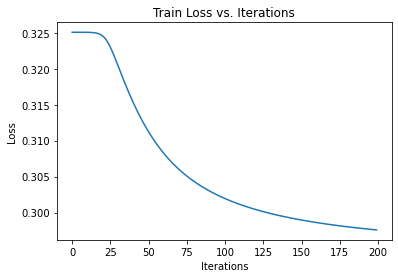

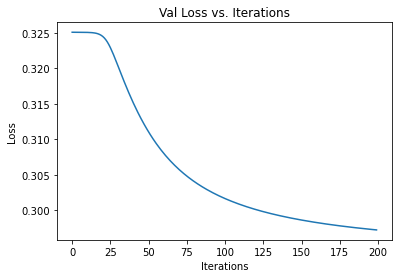

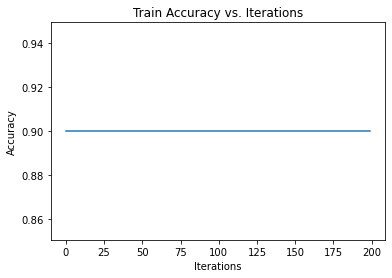

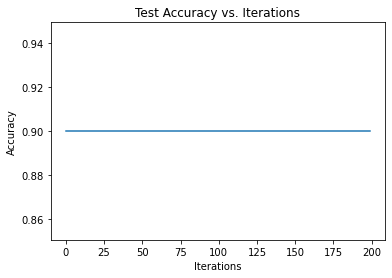

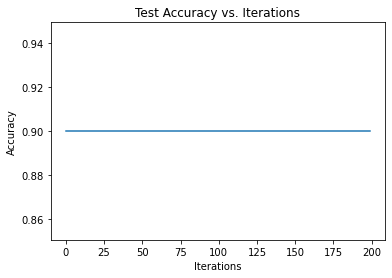

In [30]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd

train_data = pd.read_csv('C:/Users/HP/Desktop/fashion-mnist_train.csv')
test_data = pd.read_csv("C:/Users/HP/Desktop/fashion-mnist_test.csv")

# Split data into features and labels
X_train = train_data.drop("label", axis=1).values
X_test= test_data.drop("label", axis=1).values
y_train = train_data["label"].values
y_test = test_data["label"].values
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train)

# Perform one-hot encoding of labels
one_hot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_val_onehot = one_hot_encoder.fit_transform(y_val.reshape(-1, 1))
y_test_onehot = one_hot_encoder.transform(y_test.reshape(-1, 1))

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, num_classes, init_type='zeros'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_classes = num_classes
        self.init_type = init_type
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.m = X_train.shape[1]
        self.y_test = y_test
        self.num_classes = num_classes
        self.y_train_onehot = np.eye(num_classes)[y_train.reshape(-1)]
        self.initialize_weights()

    def sigmoid(self, z):
        z = np.clip(z, -700, 700) # prevent overflow
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0) * 1.0

    def softmax(self, x):
        x = np.array(x)
        x = np.where(np.isnan(x), -sys.float_info.max, x)
        x = np.where(np.isinf(x), sys.float_info.max, x)
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=1, keepdims=True)
    
    def initialize_weights(self):
        W1 = np.zeros((self.input_size, self.hidden_size))
        b1 = np.zeros((1, self.hidden_size))
        W2 = np.zeros((self.hidden_size, self.output_size))
        b2 = np.zeros((1, self.output_size))
        return W1, b1, W2, b2
    
    def initialize_weights1(self):
        W1 = np.random.normal(size=(self.input_size, self.hidden_size))
        b1 = np.random.normal(size=(1, self.hidden_size))
        W2 = np.random.normal(size=(self.hidden_size, self.output_size))
        b2 = np.random.normal(size=(1, self.output_size))
        return W1, b1, W2, b2
    
################################################# Sigmoid  + Zeros #######################################################
    def train1(self, X_train, y_train_onehot, X_test, y_test_onehot, learning_rate=0.01, num_iterations=200):
        W1, b1, W2, b2 = self.initialize_weights()
        m = X_train.shape[0]
        
        loss_history = []
        loss_history1 = []
        accuracy_history = []
        acc_train = []
        acc_val = []

        for i in range(num_iterations):
            # Forward pass
            z1 = np.dot(X_train, W1) + b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)

            # Calculate loss
            eps = 1e-10 # small constant to prevent division by zero
            loss = -np.mean(y_train_onehot * np.log(a2 + eps) + (1 - y_train_onehot) * np.log(1 - a2 + eps))
            loss_history.append(loss)
            
            # Backward pass
            dz2 = a2 - y_train_onehot
            da1 = np.dot(dz2, W2.T) * self.sigmoid_derivative(a1)
            dW2 = np.dot(a1.T, dz2) / m
            db2 = np.sum(dz2, axis=0, keepdims=True) / m
            dW1 = np.dot(X_train.T, da1) / m
            db1 = np.sum(da1, axis=0, keepdims=True) / m
            
            z1 = np.dot(X_val, W1) + b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)

            # Calculate loss
            eps = 1e-10 # small constant to prevent division by zero
            loss = -np.mean(y_val_onehot * np.log(a2 + eps) + (1 - y_val_onehot) * np.log(1 - a2 + eps))
            loss_history1.append(loss)

            # Backward pass
            dz2 = a2 - y_val_onehot
            da1 = np.dot(dz2, W2.T) * self.sigmoid_derivative(a1)
            dW2 = np.dot(a1.T, dz2) / m
            db2 = np.sum(dz2, axis=0, keepdims=True) / m
            dW1 = np.dot(X_val.T, da1) / m
            db1 = np.sum(da1, axis=0, keepdims=True) / m

            # Update weights and biases
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2

            # Predict on test data
            z1 = np.dot(X_test, W1) + b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)

            # Calculate accuracy on test data
            predictions = np.round(a2)
            accuracy = np.mean(np.equal(predictions, y_test_onehot).astype(int))    
            accuracy_history.append(accuracy)
            
            # Calculate accuracy on train data
            z1 = np.dot(X_train, W1) + b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)
            
            predictions1 = np.round(a2)
            accuracy = np.mean(np.equal(predictions1, y_train_onehot).astype(int))    
            acc_train.append(accuracy)

            
            # Calculate accuracy on train data
            z1 = np.dot(X_val, W1) + b1
            a1 = self.sigmoid(z1)
            z2 = np.dot(a1, W2) + b2
            a2 = self.softmax(z2)
            
            predictions1 = np.round(a2)
            accuracy = np.mean(np.equal(predictions1, y_val_onehot).astype(int))    
            acc_val.append(accuracy)
            
        print("Maximum accuracy on test data: ", max(accuracy_history))

        
        # Plot the accuracy curve
        plt.plot(loss_history)
        plt.title("Train Loss vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
        
        # Plot the accuracy curve
        plt.plot(loss_history1)
        plt.title("Val Loss vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
        
        
        # Plot the loss curve
        plt.plot(accuracy_history)
        plt.title("Train Accuracy vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.show()

        plt.plot(acc_val)
        plt.title("Test Accuracy vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.show()
        

model1 = NeuralNetwork(input_size=X_train.shape[1], hidden_size=128, output_size=10,num_classes=10)
model1.train1(X_train, y_train_onehot, X_test, y_test_onehot, learning_rate=0.01, num_iterations=200)
